
# Практическое задание 6. Бустинговое


## Описание




Жёсткий дедлайн: 24.12.2023 23:59 MSK

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Неэффективная реализация кода может негативно отразиться на оценке.

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [ ]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style='darkgrid')
filterwarnings('ignore')

In [ ]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустингового (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2

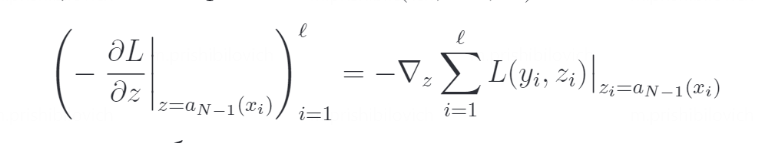
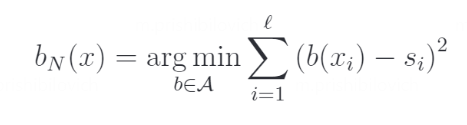

In [ ]:
from __future__ import annotations
from collections import defaultdict
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeRegressor


def score(clf, x, y):
    return roc_auc_score(y == 1, clf.predict_proba(x)[:, 1])


class Boosting:

    def __init__(
            self,
            base_model_params: dict = None,
            n_estimators: int = 10,
            learning_rate: float = 0.1,
            subsample: float = 0.3,
            early_stopping_rounds: int = None,
            plot: bool = False,
    ):
        self.base_model_class = DecisionTreeRegressor
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate
        self.subsample: float = subsample

        self.early_stopping_rounds: int = early_stopping_rounds
        if early_stopping_rounds is not None:
            self.validation_loss = np.full(self.early_stopping_rounds, np.inf)

        self.plot: bool = plot

        # self.history = defaultdict(list)
        self.history = []

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def _fit_new_base_model(self, x, y, predictions):
        sub_size = int(self.subsample * y.shape[0])
        index = np.random.choice(y.shape[0], sub_size)
        x, y, predictions = x[index], y[index], predictions[index]
        base_model = self.base_model_class(**self.base_model_params)
        s = - self.loss_derivative(y, predictions)
        base_model.fit(x, s)
        old_predictions = self.predict_proba(x)[:, 1] # модели N-1
        new_predictions = self.sigmoid(base_model.predict(x)) # N
        opt_gamma = self.find_optimal_gamma(y, old_predictions, new_predictions) # оптимизировали гамму

        self.gammas.append(opt_gamma) # добавили модель в ансамбль
        self.models.append(base_model)

    def fit(self, x_train, y_train, x_valid, y_valid):
        """
        :param x_train: features array (train set)
        :param y_train: targets array (train set)
        :param x_valid: features array (validation set)
        :param y_valid: targets array (validation set)
        """
        self.train_predictions = np.zeros(y_train.shape[0])
        self.valid_predictions = np.zeros(y_valid.shape[0])

        for _ in range(self.n_estimators):
            self._fit_new_base_model(x_train, y_train, self.train_predictions)
            self.train_predictions = self.predict_proba(x_train)[:, 1]
            self.history.append(self.score(x_valid, y_valid))

            if self.early_stopping_rounds is not None:
                if _ < self.early_stopping_rounds:
                    continue
                if self.history[-2] > self.history[-1]:
                    self.gammas = self.gammas[:-1]
                    self.models = self.models[:-1]
                    break


        if self.plot:
            plt.plot(self.history)

    def predict_proba(self, x):
        pred = np.zeros(x.shape[0])
        for gamma, model in zip(self.gammas, self.models):
            pred += gamma * model.predict(x)
        return np.column_stack((1 - self.sigmoid(pred), self.sigmoid(pred)))

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]

        return gammas[np.argmin(losses)]

    def score(self, x, y):
        return score(self, x, y)

    @property
    def feature_importances_(self):
        pass

### Проверка кода

У автора задания всё учится около одной секунды.

CPU times: user 2.45 s, sys: 6.13 ms, total: 2.45 s
Wall time: 3.23 s
Train ROC-AUC 0.9896
Valid ROC-AUC 0.9117
Test ROC-AUC 0.9111


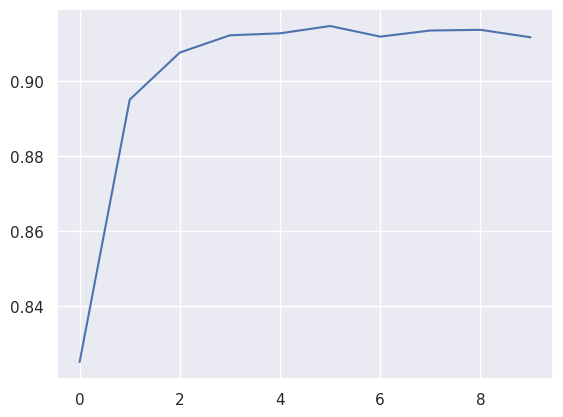

In [ ]:
boosting = Boosting(plot = True)

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

## Задание 2. Обучение градиентного бустингового (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

In [ ]:
trains, tests = [], []

depths = range(1, 30, 2)

for depth in depths:
  boosting = Boosting(base_model_params = {'max_depth': depth})
  boosting.fit(x_train, y_train, x_valid, y_valid)
  trains.append(boosting.score(x_train, y_train))
  tests.append(boosting.score(x_test, y_test))

<function matplotlib.pyplot.show(close=None, block=None)>

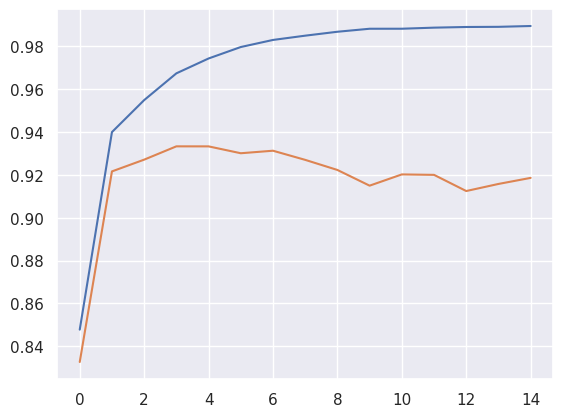

In [ ]:
plt.plot(trains)
plt.plot(tests)
plt.legend
plt.show

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

depth = 4: емкости достаточно для хорошего результата, глубины деревьев недостаточно для переобучения

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (3 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей. Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/).

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.5 MB/s eta 0:00:00


In [ ]:
import optuna

def objective(trial):
    params = {
        # "objective": "regression",
        # "metric": "rmse",
        # "n_estimators": 1000,
        # "verbosity": -1,
        # "bagging_freq": 1,
        # "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        # "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),

        'base_model_params': None,
        'n_estimators': trial.suggest_int("n_estimators", 2, 20),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1, log=True),
        'subsample': trial.suggest_float("subsample", 0.1, 0.7),
        'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 3, 15),
        'plot': False,
    }

    model = Boosting(**params)
    model.fit(x_train, y_train, x_valid, y_valid)
    auc = model.score(x_test, y_test)
    return auc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

[I 2023-12-24 10:06:23,509] A new study created in memory with name: no-name-31f88d92-7b2d-4765-a907-11cdfd68e7a6
[I 2023-12-24 10:06:27,355] Trial 0 finished with value: 0.903918217416154 and parameters: {'n_estimators': 9, 'learning_rate': 0.005999534617171522, 'subsample': 0.6636746932957469, 'early_stopping_rounds': 13}. Best is trial 0 with value: 0.903918217416154.
[I 2023-12-24 10:06:30,799] Trial 1 finished with value: 0.9250003542620878 and parameters: {'n_estimators': 19, 'learning_rate': 0.2812652350075609, 'subsample': 0.21266799351112306, 'early_stopping_rounds': 13}. Best is trial 1 with value: 0.9250003542620878.
[I 2023-12-24 10:06:32,729] Trial 2 finished with value: 0.9017580059295601 and parameters: {'n_estimators': 19, 'learning_rate': 0.005851814784549232, 'subsample': 0.4924527406547655, 'early_stopping_rounds': 4}. Best is trial 1 with value: 0.9250003542620878.
[I 2023-12-24 10:06:41,180] Trial 3 finished with value: 0.9245346964288808 and parameters: {'n_estima

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best AUC:', study.best_value)

Best hyperparameters: {'n_estimators': 19, 'learning_rate': 0.2812652350075609, 'subsample': 0.21266799351112306, 'early_stopping_rounds': 13}
Best AUC: 0.9250003542620878


In [ ]:
import optuna

def objective(trial):
    params = {
        'base_model_params': {
            'max_depth': trial.suggest_int("max_depth", 1, 20),
            'min_samples_split': trial.suggest_int("min_samples_split", 2, 100),
            'min_samples_leaf':trial.suggest_int("min_samples_leaf", 1, 100)
            },
        'n_estimators': trial.suggest_int("n_estimators", 2, 20),
        'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1, log=True),
        'subsample': trial.suggest_float("subsample", 0.1, 0.7),
        'early_stopping_rounds': trial.suggest_int("early_stopping_rounds", 3, 15),
        'plot': False,
    }

    model = Boosting(**params)
    model.fit(x_train, y_train, x_valid, y_valid)
    auc = model.score(x_test, y_test)
    return auc

In [ ]:
study1 = optuna.create_study(direction='maximize')
study1.optimize(objective, n_trials=10)

[I 2023-12-24 10:06:56,504] A new study created in memory with name: no-name-7a0fb4a4-9ff2-4d1a-a3f9-eabd1ae6cdf5
[I 2023-12-24 10:06:57,911] Trial 0 finished with value: 0.9206598564372571 and parameters: {'max_depth': 3, 'min_samples_split': 90, 'min_samples_leaf': 50, 'n_estimators': 19, 'learning_rate': 0.00224603333356248, 'subsample': 0.677759824748386, 'early_stopping_rounds': 15}. Best is trial 0 with value: 0.9206598564372571.
[I 2023-12-24 10:06:58,384] Trial 1 finished with value: 0.8442085233883831 and parameters: {'max_depth': 1, 'min_samples_split': 50, 'min_samples_leaf': 5, 'n_estimators': 14, 'learning_rate': 0.10090662437567974, 'subsample': 0.2194246232104741, 'early_stopping_rounds': 9}. Best is trial 0 with value: 0.9206598564372571.
[I 2023-12-24 10:06:58,772] Trial 2 finished with value: 0.9311857703153563 and parameters: {'max_depth': 12, 'min_samples_split': 17, 'min_samples_leaf': 48, 'n_estimators': 11, 'learning_rate': 0.06413408698915682, 'subsample': 0.230

In [ ]:
print('Best hyperparameters:', study1.best_params)
print('Best AUC:', study1.best_value)

Best hyperparameters: {'max_depth': 17, 'min_samples_split': 73, 'min_samples_leaf': 90, 'n_estimators': 18, 'learning_rate': 0.0559815387064771, 'subsample': 0.6397935598259722, 'early_stopping_rounds': 13}
Best AUC: 0.9326217126446373


In [ ]:
study2 = optuna.create_study(direction='maximize')
study2.optimize(objective, n_trials=100)

[I 2023-12-24 10:07:13,657] A new study created in memory with name: no-name-00b59650-b658-4371-81f9-e59a05396d6d
[I 2023-12-24 10:07:15,445] Trial 0 finished with value: 0.9328389933918312 and parameters: {'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 22, 'n_estimators': 8, 'learning_rate': 0.010252210105374018, 'subsample': 0.4669653417109265, 'early_stopping_rounds': 7}. Best is trial 0 with value: 0.9328389933918312.
[I 2023-12-24 10:07:17,567] Trial 1 finished with value: 0.930013162804685 and parameters: {'max_depth': 10, 'min_samples_split': 88, 'min_samples_leaf': 94, 'n_estimators': 16, 'learning_rate': 0.15332007451464974, 'subsample': 0.32956504751212, 'early_stopping_rounds': 14}. Best is trial 0 with value: 0.9328389933918312.
[I 2023-12-24 10:07:18,266] Trial 2 finished with value: 0.9237009996488869 and parameters: {'max_depth': 10, 'min_samples_split': 32, 'min_samples_leaf': 21, 'n_estimators': 2, 'learning_rate': 0.002766952809108287, 'subsample': 0.600

In [ ]:
print('Best hyperparameters:', study2.best_params)
print('Best AUC:', study2.best_value)

Best hyperparameters: {'max_depth': 15, 'min_samples_split': 69, 'min_samples_leaf': 4, 'n_estimators': 19, 'learning_rate': 0.6268690628302516, 'subsample': 0.35319605399770354, 'early_stopping_rounds': 15}
Best AUC: 0.9369964558046237


In [ ]:
 best_params = {
        'base_model_params': {
            'max_depth': 17,
            'min_samples_split': 65,
            'min_samples_leaf':4
            },
        'n_estimators': 19,
        'learning_rate': 0.0014067329255326535,
        'subsample': 0.6745750178154618,
        'early_stopping_rounds': 15,
        'plot': True,
    }

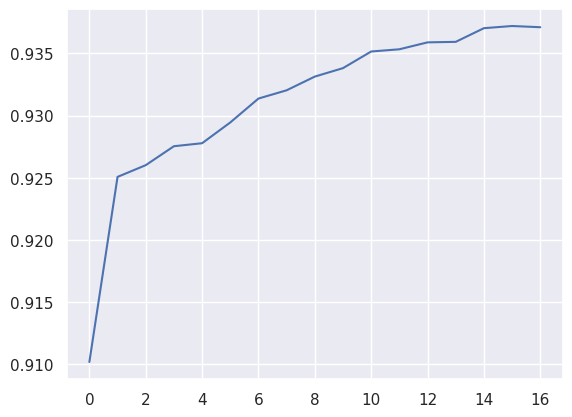

In [ ]:
model = Boosting(**best_params)
model.fit(x_train, y_train, x_valid, y_valid)

## Задание 4. Интерпретация бустингового (2 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

In [ ]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

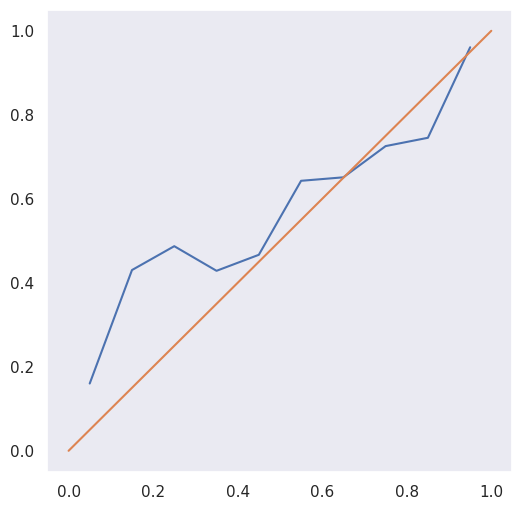

In [ ]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 * i / n_bins
        r = 1.0 * (i + 1) / n_bins
        # bin_middle_points.append((l - r) / 2)
        bin_middle_points.append(l + (r - l) / 2) # средние точки должны сдвигаться вправо

        # bin_real_ratios.append(np.min(y_test[(preds >= l) & (preds < r)] == 1))
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1) / (y_test[(preds >= l) & (preds < r)]).shape)
        # Здесь нужно считать долю единичек на отрезке

    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.plot([0, 1], [0, 1])

plot_calibration_curve(y_test, model.predict_proba(x_test)[:, 1])

In [ ]:
# ну чето так себе :(

# бустинг недооценивает вероятность 0

In [ ]:
y.mean()

0.30018697943226247

In [ ]:
# недооценкка бустингом может быть связана с дисбалансом классов

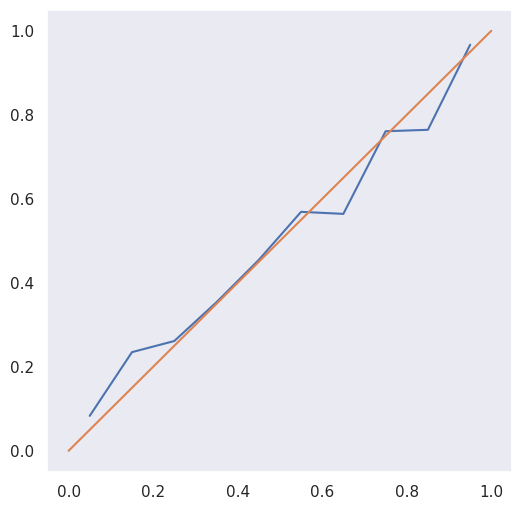

In [ ]:
plot_calibration_curve(y_test, LogisticRegression(random_state = 1337).fit(x_train, y_train).predict_proba(x_test)[:, 1])

In [ ]:
# логрег оказывается ближе к идеально откалиброванному классификатору

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

In [ ]:
class Boosting:

    def __init__(
            self,
            base_model_params: dict = None,
            n_estimators: int = 10,
            learning_rate: float = 0.1,
            subsample: float = 0.3,
            early_stopping_rounds: int = None,
            plot: bool = False,
    ):
        self.base_model_class = DecisionTreeRegressor
        self.base_model_params: dict = {} if base_model_params is None else base_model_params

        self.n_estimators: int = n_estimators

        self.models: list = []
        self.gammas: list = []

        self.learning_rate: float = learning_rate
        self.subsample: float = subsample

        self.early_stopping_rounds: int = early_stopping_rounds
        if early_stopping_rounds is not None:
            self.validation_loss = np.full(self.early_stopping_rounds, np.inf)

        self.plot: bool = plot

        # self.history = defaultdict(list)
        self.history = []

        self.sigmoid = lambda x: 1 / (1 + np.exp(-x))
        self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
        self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)

    def _fit_new_base_model(self, x, y, predictions):
        sub_size = int(self.subsample * y.shape[0])
        index = np.random.choice(y.shape[0], sub_size)
        x, y, predictions = x[index], y[index], predictions[index]
        base_model = self.base_model_class(**self.base_model_params)
        s = - self.loss_derivative(y, predictions)
        base_model.fit(x, s)
        old_predictions = self.predict_proba(x)[:, 1] # модели N-1
        new_predictions = self.sigmoid(base_model.predict(x)) # N
        opt_gamma = self.find_optimal_gamma(y, old_predictions, new_predictions) # оптимизировали гамму

        self.gammas.append(opt_gamma) # добавили модель в ансамбль
        self.models.append(base_model)

    def fit(self, x_train, y_train, x_valid, y_valid):
        """
        :param x_train: features array (train set)
        :param y_train: targets array (train set)
        :param x_valid: features array (validation set)
        :param y_valid: targets array (validation set)
        """
        self.train_predictions = np.zeros(y_train.shape[0])
        self.valid_predictions = np.zeros(y_valid.shape[0])

        for _ in range(self.n_estimators):
            self._fit_new_base_model(x_train, y_train, self.train_predictions)
            self.train_predictions = self.predict_proba(x_train)[:, 1]
            self.history.append(self.score(x_valid, y_valid))

            if self.early_stopping_rounds is not None:
                if _ < self.early_stopping_rounds:
                    continue
                if self.history[-2] > self.history[-1]:
                    self.gammas = self.gammas[:-1]
                    self.models = self.models[:-1]
                    break


        if self.plot:
            plt.plot(self.history)

    def predict_proba(self, x):
        pred = np.zeros(x.shape[0])
        for gamma, model in zip(self.gammas, self.models):
            pred += gamma * model.predict(x)
        return np.column_stack((1 - self.sigmoid(pred), self.sigmoid(pred)))

    def find_optimal_gamma(self, y, old_predictions, new_predictions) -> float:
        gammas = np.linspace(start=0, stop=1, num=100)
        losses = [self.loss_fn(y, old_predictions + gamma * new_predictions) for gamma in gammas]

        return gammas[np.argmin(losses)]

    def score(self, x, y):
        return score(self, x, y)

    @property
    def feature_importances_(self):
        feature_importances = np.zeros(self.models[0].feature_importances_.shape[0])
        for gamma, model in zip(self.gammas, self.models):
            feature_importances += gamma * model.feature_importances_
        return feature_importances / self.n_estimators

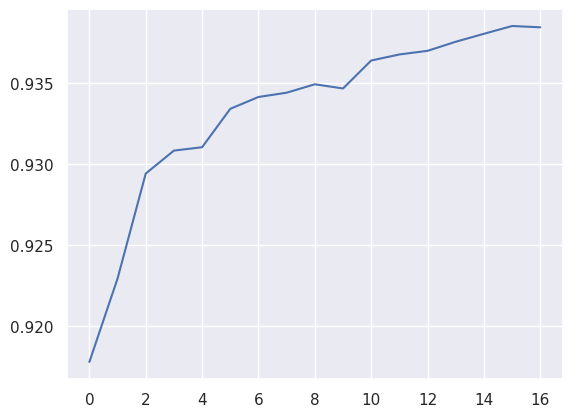

In [ ]:
model = Boosting(**best_params)
model.fit(x_train, y_train, x_valid, y_valid)

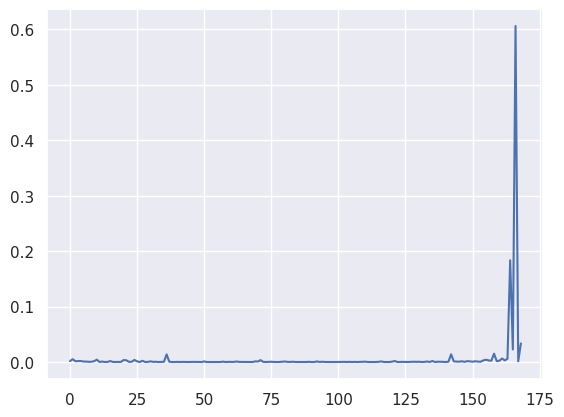

In [ ]:
plt.plot(model.feature_importances_ / model.feature_importances_.sum());

In [ ]:
import pandas as pd

<Axes: ylabel='Feature'>

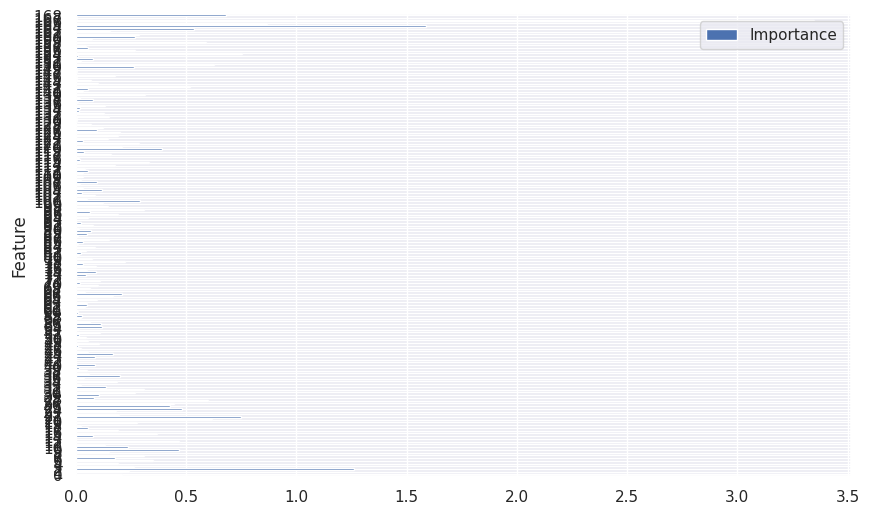

In [ ]:
from sklearn.preprocessing import StandardScaler
boba = StandardScaler()
lr = LogisticRegression(random_state = 1337).fit(boba.fit_transform(x_train.toarray()), y_train)
coefficients = lr.coef_[0]
cof = pd.DataFrame({'Feature': range(x_train.shape[1]), 'Importance': np.abs(coefficients)})
cof.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

In [ ]:
# бустинг обращает внимание на несколько фичей, логрег - на треть
# причина может быть в том, что большинство деревьев в бустинге так или иначе обращают внимание на самые
# подходящие для сплита признаки

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

In [ ]:
ind_30 = np.argpartition(model.feature_importances_ / model.feature_importances_.sum(), -150)[-150:]
top = model.feature_importances_[ind_30] / model.feature_importances_.sum()
print(f'Test ROC-AUC {model.score(x_test, y_test):.4f}')

Test ROC-AUC 0.9370


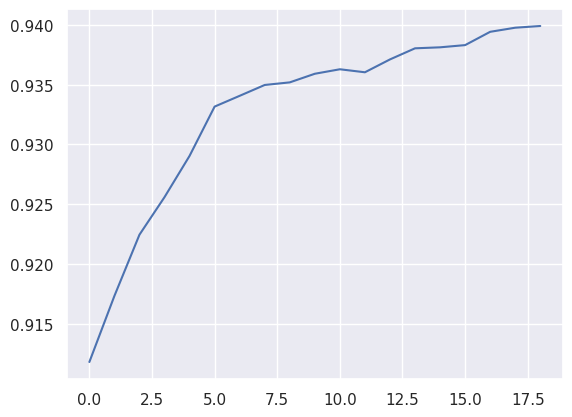

In [ ]:
model = Boosting(**best_params)
model.fit(x_train[:, ind_30], y_train, x_valid[:, ind_30], y_valid)

In [ ]:
print(f'Test ROC-AUC {model.score(x_test[:, ind_30], y_test):.4f}')

Test ROC-AUC 0.9347


In [ ]:
# я пробовал взять 30, 100 и 150 лучших признаков - во всех случаях качество на тесте упало

## Задание 5 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [ ]:
# YOUR CODE:

## Задание 6 (бонус). Катбустовое (1 балл)

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

In [ ]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.7 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=10, learning_rate=1, depth=2)
# Fit model
model.fit(x_train, y_train)
# Get predictions
score(model, x_train, y_train)

0:	learn: 0.3802937	total: 11.2ms	remaining: 11.2ms
1:	learn: 0.3460453	total: 19.5ms	remaining: 0us


0.913858626462469

In [ ]:
# сходу не обогнал)

In [ ]:
model = CatBoostClassifier(iterations=19, learning_rate=0.002, depth=16)
# Fit model
model.fit(x_train, y_train)
# Get predictions
score(model, x_train, y_train)

0:	learn: 0.6903093	total: 2.5s	remaining: 45s
1:	learn: 0.6874586	total: 2.8s	remaining: 23.8s
2:	learn: 0.6846085	total: 4.21s	remaining: 22.4s
3:	learn: 0.6818311	total: 6.02s	remaining: 22.6s
4:	learn: 0.6792707	total: 6.04s	remaining: 16.9s
5:	learn: 0.6768841	total: 6.06s	remaining: 13.1s
6:	learn: 0.6742143	total: 8.63s	remaining: 14.8s
7:	learn: 0.6718265	total: 8.64s	remaining: 11.9s
8:	learn: 0.6690864	total: 10.5s	remaining: 11.6s
9:	learn: 0.6663637	total: 10.7s	remaining: 9.67s
10:	learn: 0.6636694	total: 12.5s	remaining: 9.07s
11:	learn: 0.6610237	total: 14.2s	remaining: 8.28s
12:	learn: 0.6585575	total: 15.9s	remaining: 7.35s
13:	learn: 0.6559451	total: 17.3s	remaining: 6.17s
14:	learn: 0.6537901	total: 17.3s	remaining: 4.61s
15:	learn: 0.6512828	total: 18.7s	remaining: 3.5s
16:	learn: 0.6487061	total: 21s	remaining: 2.47s
17:	learn: 0.6462776	total: 23.3s	remaining: 1.29s
18:	learn: 0.6438049	total: 25s	remaining: 0us


0.9620612432139581

In [ ]:
# Даже без оптюны получилось лучше. Великая компания!

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2024 года?

In [ ]:
# Встречать буду дома, в Питере, с девушкой и друзьями.
# Весну-лето проведу в мск на мобильности и на работе. Будет сложно, но круто!)

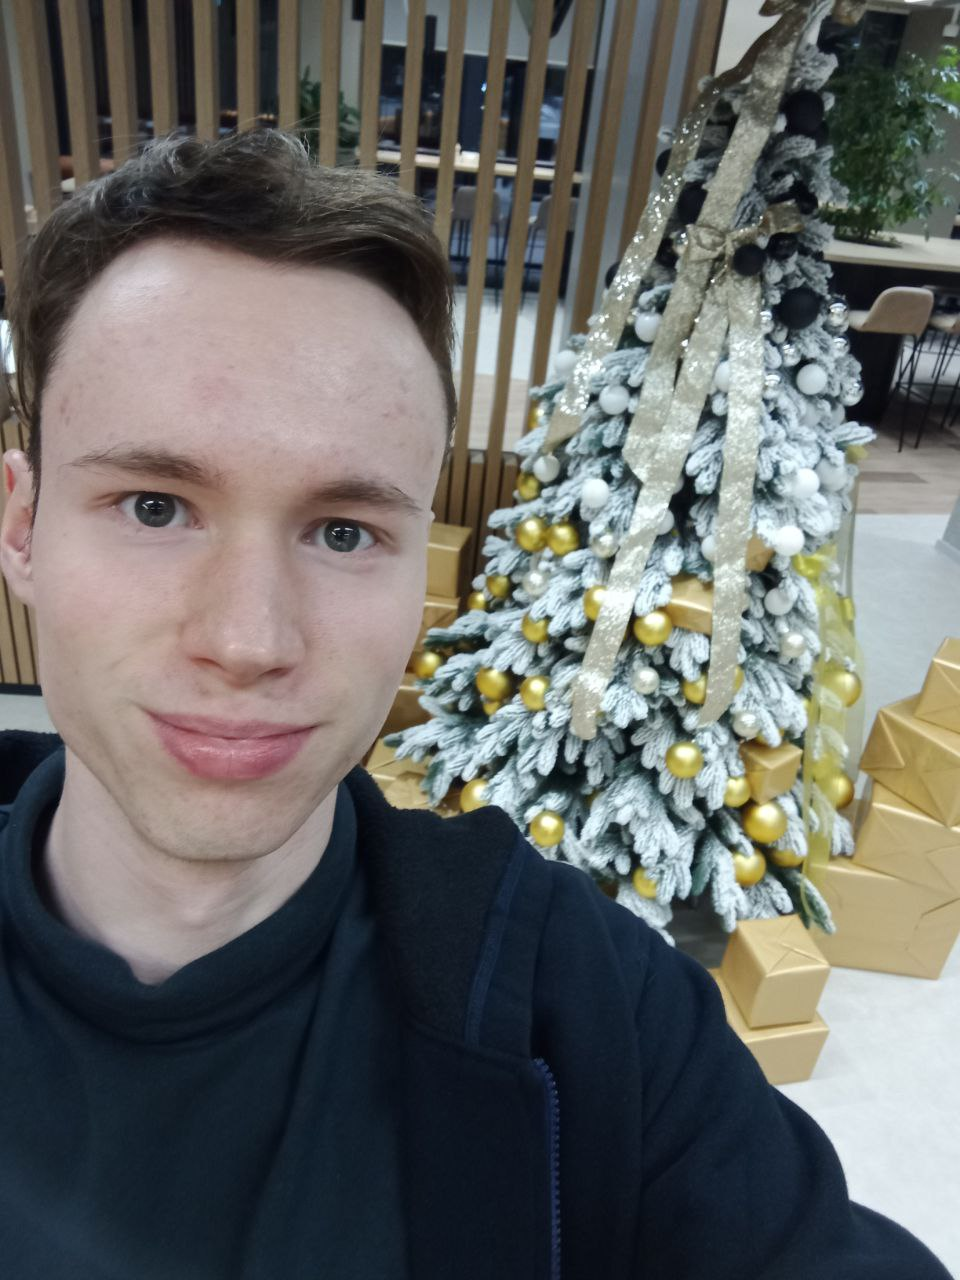